In [1]:
!pip install -q -U keras-tuner

In [2]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kerastuner as kt
import time

In [3]:
# mount google drive to access data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# define paths
# dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection
path = "/content/drive/My Drive/01 - Courses/04 - Machine Learning Engineer Nanodegree/brain_tumor_detection/data/dataset"

In [5]:
# define parameters
img_height = 128
img_width = 128
img_size = (img_height, img_width)
n_augmented_images = 10

In [6]:
# define augmentation layer (https://neptune.ai/blog/data-augmentation-in-python)
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
     layers.experimental.preprocessing.RandomZoom(0.1)])

In [7]:
def augment_image(image, n_augmented_images):
  '''
  Returns a list of augmented images for the given input image
  Arguments:
  image (array) - input image
  number_of_images (int) - number of augmented images to return
  Returns:
  images (list) - list of augmented images
  '''

  image = tf.expand_dims(image, 0)
  images = []

  for i in range(n_augmented_images):
    augmented_image = data_augmentation(image)
    images.append(np.array(augmented_image[0]))

  return images

In [8]:
def preprocess_data(path, img_size, n_augmented_images):
  '''
  Reads in images classified into folders, resizes and scales them. Returns 
  those processed images as features and their associated labels as well.
  Arguments:
    path (str) - path to classified image folders
    img_size (tuple) - tuple containing resized image height and width
  Returns:
    X (array) - features (brain scan images)
    y (array) - feature labels (0 - no tumor, 1 - tumor)
  '''

  unsuccessful_files = {}

  X = []
  y = []

  for folder_name in os.listdir(path):
    if folder_name == 'no':
      label = 0
    else:
      label = 1
    folder_path = os.path.join(path, folder_name)
  
    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)
      try:
        img = cv2.imread(fpath)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        X += augment_image(img, n_augmented_images)
        y += [label] * n_augmented_images

      except Exception as e:
        unsuccessful_files[fname] = e

  if unsuccessful_files:
    print(f'Error processing the following files:\n')
    for index, key in enumerate(unsuccessful_files, 1):
      print(f'{index}. {key} - {unsuccessful_files[key]}')
  else:
    print('Successfully processed all images.')

  X = np.array(X)
  y = np.array(y)

  return X, y

In [43]:
# obtain features and labels
X, y = preprocess_data(path, img_size, n_augmented_images)

Successfully processed all images.


In [10]:
print(f'After augmentation, our dataset now has {len(X)} samples.')

After augmentation, our dataset now has 2530 samples.


In [11]:
# split data into train, validation and test sets
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

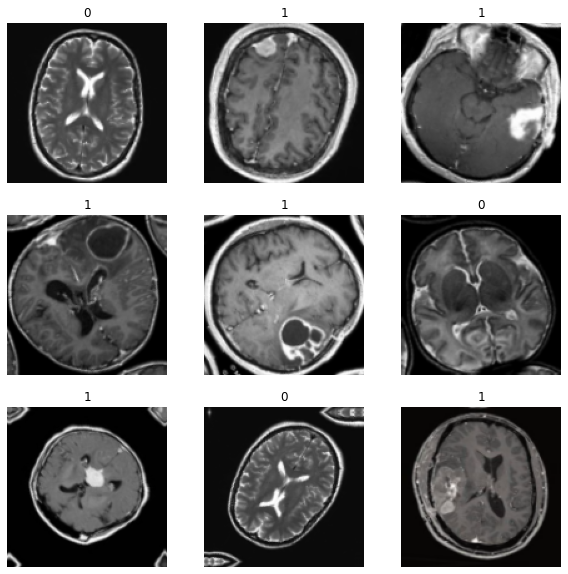

In [12]:
# visualize first 9 images in the training dataset
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis("off")

In [13]:
# create the model
def model_builder(hp):
  model = Sequential([
    layers.Input((img_height, img_width, 3)),
    layers.Conv2D(hp.Int('conv2d_1_units', min_value=16, max_value=64, step=16), 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(hp.Int('conv2d_2_units', min_value=16, max_value=64, step=16), 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(hp.Int('conv2d_3_units', min_value=16, max_value=64, step=16), 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1)),
    layers.Flatten(),
    layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'),
    layers.Dense(1, activation='sigmoid')
  ])

  # compile the model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
  return model

In [14]:
LOG_DIR = f"{int(time.time())}"
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory=LOG_DIR)

In [15]:
# perform hyperparameter search
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
tuner.search(X_train,
             y_train,
             batch_size=32,
             validation_data=(X_val, y_val),
             epochs=20,
             callbacks=[early_stop])

Trial 30 Complete [00h 09m 04s]
val_accuracy: 0.7634069323539734

Best val_accuracy So Far: 0.801261842250824
Total elapsed time: 02h 25m 06s
INFO:tensorflow:Oracle triggered exit


In [37]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.get_best_hyperparameters()[0].values

{'conv2d_1_units': 48,
 'conv2d_2_units': 32,
 'conv2d_3_units': 32,
 'dense_units': 128,
 'dropout': 0.1,
 'tuner/bracket': 0,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}

In [44]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[early_stop])

Epoch 1/20
60/60 [==============================] - 52s 848ms/step - loss: 0.5927 - accuracy: 0.6852 - val_loss: 0.6061 - val_accuracy: 0.6719
Epoch 2/20
60/60 [==============================] - 51s 847ms/step - loss: 0.4941 - accuracy: 0.7717 - val_loss: 0.5807 - val_accuracy: 0.7508
Epoch 3/20
60/60 [==============================] - 49s 815ms/step - loss: 0.4785 - accuracy: 0.7731 - val_loss: 0.6118 - val_accuracy: 0.7634
Epoch 4/20
60/60 [==============================] - 49s 820ms/step - loss: 0.4345 - accuracy: 0.8046 - val_loss: 0.5613 - val_accuracy: 0.7476
Epoch 5/20
60/60 [==============================] - 50s 826ms/step - loss: 0.3401 - accuracy: 0.8453 - val_loss: 0.6015 - val_accuracy: 0.7098
Epoch 6/20
60/60 [==============================] - 50s 838ms/step - loss: 0.2793 - accuracy: 0.8842 - val_loss: 0.6793 - val_accuracy: 0.7539
Epoch 7/20
60/60 [==============================] - 50s 840ms/step - loss: 0.2115 - accuracy: 0.9204 - val_loss: 0.8495 - val_accuracy: 0.6972

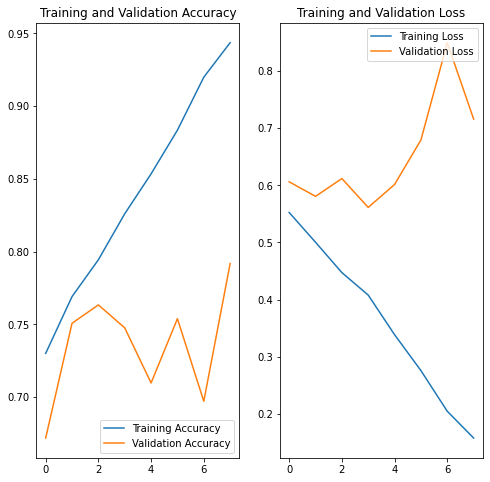

In [45]:
# visualize the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(early_stop.stopped_epoch + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [46]:
# make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.squeeze(y_pred).round().astype(int)

In [47]:
# classifiation report
from sklearn.metrics import classification_report , confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.82      0.76       114
           1       0.89      0.82      0.85       202

    accuracy                           0.82       316
   macro avg       0.80      0.82      0.81       316
weighted avg       0.83      0.82      0.82       316



In [48]:
# confusion matrix
actual_labels = ['no_tumor', 'tumor']
pred_labels = ['predicted_no_tumor', 'predicted_tumor']
matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(matrix, index=actual_labels, columns=pred_labels)
matrix_df

,predicted_no_tumor,predicted_tumor
no_tumor,93,21
tumor,37,165
